In [1]:
import numpy as np
import uproot
from scipy import interpolate

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def GetFVCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
               & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
               & (tree['standoff'].array() > 20.0) \
               & (tree['energy'].array() > 2435) \
               & (tree['energy'].array() < 2481) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

def Get2tCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
               & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
               & (tree['standoff'].array() > 104.0) \
               & (tree['energy'].array() > 2435) \
               & (tree['energy'].array() < 2481) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

In [3]:
Path = '/p/vast1/nexo/data/merged-v11/'
bb0n = uproot.open(Path+'Baseline2019_bb0n_FullLXe.root')['tree']
u238 = uproot.open(Path+'Baseline2019_U238_TPCVessel.root')['tree']
# th232 = uproot.open(Path+'Baseline2019_Th232_TPCVessel.root')['tree']

In [4]:
bb0n_cut = GetFVCut(bb0n)
# th232_cut = GetFVCut(th232)
u238_cut = GetFVCut(u238)

In [5]:
def smooth(x, smooth_factor):
#     print(smooth_factor)
#     print(x.mean())
    if smooth_factor:
        rnd = np.random.normal(0, smooth_factor, len(x))
        x += rnd
        x = np.where(x > 1, 1 - x - np.modf(x)[1], x)
        x = np.where(x < 0, np.modf(x)[1] - x, x)
#         print(x.mean())
    return x

In [6]:
def truncated_smooth(x, smooth_factor):
    if smooth_factor:
        rng = np.random.default_rng()
        for i, v in enumerate(x):
            while True:
                rnd = rng.normal(v, smooth_factor, 1)[0]
                if 0 <= rnd <= 1:
                    x[i] = rnd
                    break
    return x
            

In [7]:
def distort_onesided(x, prob, sign):
    if prob:
        rng = np.random.default_rng()
        rnd = rng.random(size=len(x))
        if sign > 0:
            x = np.where((x < 0.5) & (rnd < prob), 1.0 - x, x)
        else:
            x = np.where((x > 0.5) & (rnd < prob), 1.0 - x, x)
    return x

In [8]:
from scipy import interpolate
from hist import Hist
def distort_pdf(x, n_bins=100, m=1.0, q=0.1):
    h = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
    h.fill(x)
#     for i, v in enumerate(h):
#         if v==0: h[i] = 1e-2
    pdf = h.density()/100.
    pdf = pdf * (m*h.axes[0].edges[:-1] + q)
    pdf = pdf / sum(pdf)
#     cumul = np.cumsum(pdf, axis=0)
#     cumul = np.insert(cumul, 0, 0)
#     cumul = np.append(cumul, 1)
#     cumul = cumul / np.max(cumul)
#     print(cumul)
#     bins = [0,]
#     bins = np.append(bins, h.axes.centers[0])
#     bins = np.append(bins, 1)
#     print(bins)
#     f = interpolate.interp1d(cumul, bins, kind='cubic')
#     rng = np.random.default_rng()
#     y = rng.uniform(np.min(cumul), np.max(cumul), size=len(x))
#     print(h.sum(),len(x))
#     return f(y)
    y = rng.choice(len(pdf), size=len(x), p=pdf)
    samples = np.zeros(len(pdf), dtype=int)
    for k in y:
        samples[k] += 1
    return y * h.axes[0].widths[0] + h.axes[0].widths[0]/2.

In [9]:
bb0n_events = np.array(bb0n['m_DNNvalue'].array()[bb0n_cut])
# th232_events = np.array(th232['m_DNNvalue'].array()[th232_cut])
u238_events = np.array(u238['m_DNNvalue'].array()[u238_cut])

Smoothing factor 0.0
--> Background MisID at 85% Signal Efficiency: 7.15%
Smoothing factor 0.15
--> Background MisID at 85% Signal Efficiency: 8.57%
Smoothing factor 0.177
--> Background MisID at 85% Signal Efficiency: 9.94%
Smoothing factor 0.2
--> Background MisID at 85% Signal Efficiency: 12.27%
Smoothing factor 0.25
--> Background MisID at 85% Signal Efficiency: 19.86%


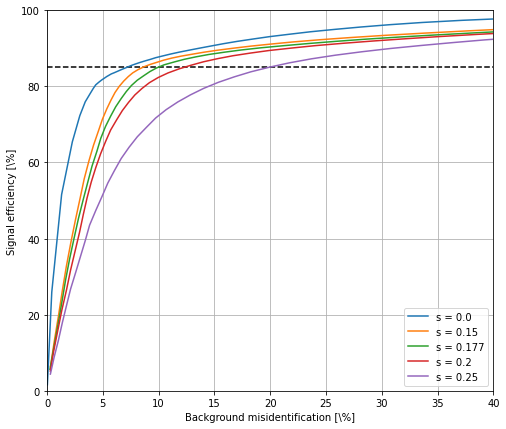

In [10]:
plt.figure(figsize=(8,7))
plt.xlim(0,40)
plt.ylim(0,100)
plt.xlabel('Background misidentification [\%]')
plt.ylabel('Signal efficiency [\%]')

bb0n_hist_d = {}
u238_hist_d = {}
results_d = {}
for smooth_f in [0., 0.15, 0.177, 0.2, 0.25]:
    SignalEfficiency = []
    BackgroundMisID_U238 = []
#     BackgroundMisID_Th232 = []

    print(f"Smoothing factor {smooth_f}")
    bb0n_events_mod = truncated_smooth(np.copy(bb0n_events), smooth_f)
    # th232_events_mod = smooth(th232_events, smooth_f)
    u238_events_mod = truncated_smooth(np.copy(u238_events), smooth_f)

#     bb0n_events_mod = distort_pdf(bb0n_events, 200, 0, 1)
#     u238_events_mod = distort_pdf(u238_events, 200, 1.0, smooth_f)
    
    bb0n_hist_d[smooth_f] = np.histogram(bb0n_events_mod, bins=np.linspace(0,1,100))
    u238_hist_d[smooth_f] = np.histogram(u238_events_mod, bins=np.linspace(0,1,100))

    DNNVals = np.arange(0,1,0.02)
    for x in DNNVals: 
        bb0n_dnn_cut = np.where(bb0n_events_mod > x)
    #     th232_dnn_cut = np.where(th232_events_mod > x)
        u238_dnn_cut = np.where(u238_events_mod > x)

        signal = len(bb0n_events_mod[bb0n_dnn_cut]) / len(bb0n_events_mod)
    #     th232_bkg = len(th232_events_mod[th232_dnn_cut]) / len(th232_events_mod)
        u238_bkg = len(u238_events_mod[u238_dnn_cut]) / len(u238_events_mod)
        # print('%.2f' % x, '%.3f' % signal, '%.3f' % u238_bkg, '%.3f' % th232_bkg)

        SignalEfficiency.append(signal)
        BackgroundMisID_U238.append(u238_bkg)
    #     BackgroundMisID_Th232.append(th232_bkg)

    SignalEfficiency = np.array(SignalEfficiency)
    BackgroundMisID_U238 = np.array(BackgroundMisID_U238)
    # BackgroundMisID_Th232 = np.array(BackgroundMisID_Th232)
    
    roc_f = interpolate.interp1d(SignalEfficiency, BackgroundMisID_U238)
    print(f'--> Background MisID at 85% Signal Efficiency: {roc_f(0.85)*100:.2f}%')
    
    plt.plot(BackgroundMisID_U238*100, SignalEfficiency*100, 
#          color=colors[0], 
         label=f's = {smooth_f}' )

plt.hlines(85, 0, 40, color='black', linestyles='dashed')
plt.grid()
plt.legend()
plt.savefig("dnn_smoothing_ROCs.png", dpi=200, bbox_inches = "tight", transparent=False, facecolor='white')

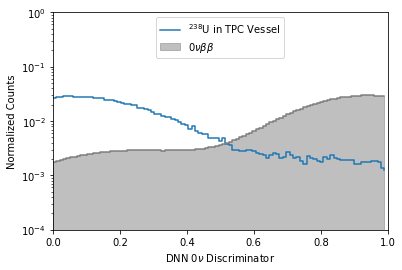

In [15]:
# for smooth_f, hist in 
smooth_f = 0.177

plt.figure()
plt.xlim(0,1)
plt.ylim(1e-4,1e0)
plt.xlabel(r'DNN $0\nu$ Discriminator')
plt.ylabel('Normalized Counts')
plt.yscale('log')

u238_histx = u238_hist_d[smooth_f][1]
u238_hist = u238_hist_d[smooth_f][0]
plt.step(x=u238_histx[:-1], 
         y=u238_hist/np.sum(u238_hist), 
         where='post', 
         label='${}^{238} \mathrm{U}$ in TPC Vessel')

# plt.step(x=th232_histx[:-1], 
#          y=th232_hist/np.sum(th232_hist), 
#          where='post', 
#          ls='--', 
#          label='${}^{232} \mathrm{Th}$ in TPC Vessel')

bb0n_histx = bb0n_hist_d[smooth_f][1]
bb0n_hist = bb0n_hist_d[smooth_f][0]
plt.step(x=bb0n_histx[:-1], 
         y=bb0n_hist/np.sum(bb0n_hist), 
         ls='-', 
         color='grey', 
         where='post', 
         label='', 
         zorder=2)

plt.fill_between(x=bb0n_histx[:-1], 
                y1=bb0n_hist/np.sum(bb0n_hist), 
                alpha=0.5, 
                color='grey', 
                step='post', 
                label=r'$0 \nu\beta\beta$',
                zorder=1)

plt.legend(loc='upper center')
plt.show()

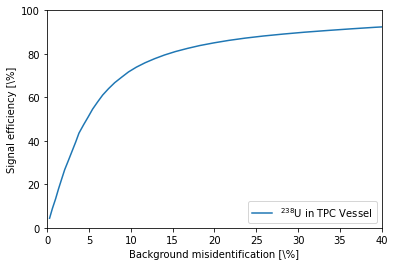

In [12]:
plt.figure()
plt.xlim(0,40)
plt.ylim(0,100)
plt.xlabel('Background misidentification [\%]')
plt.ylabel('Signal efficiency [\%]')

plt.plot(BackgroundMisID_U238*100, SignalEfficiency*100, 
         color=colors[0], 
         label='${}^{238} \mathrm{U}$ in TPC Vessel' )

# plt.plot(BackgroundMisID_Th232*100, SignalEfficiency*100, 
#          color=colors[1], 
#          ls='--', 
#          label='${}^{232} \mathrm{Th}$ in TPC Vessel')
         
plt.legend(loc='lower right')
plt.show()

In [13]:
rng = np.random.default_rng()
rng.random(size=10)

array([0.04552413, 0.4065338 , 0.62118702, 0.57127644, 0.95941652,
       0.46928126, 0.9867964 , 0.94418557, 0.57790586, 0.37434296])

len: 49132


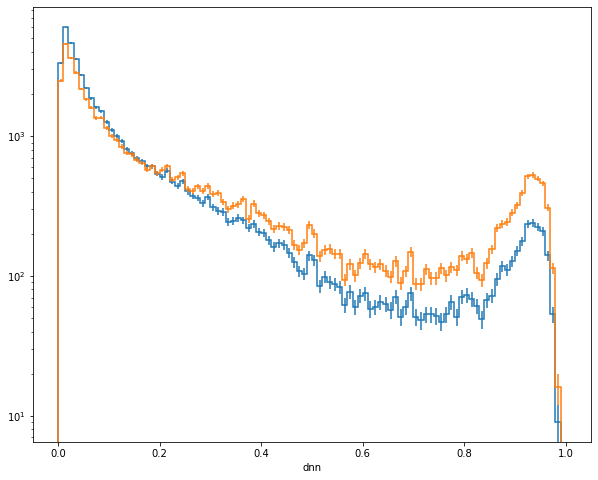

In [14]:
n_bins = 100
h = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
h.fill(u238_events)

h_mod = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
m = 1.
q = (2-m)/2.
d = distort_pdf(u238_events, n_bins, m, q)
h_mod.fill(d)
print(f"len: {len(d)}")
# h_mod[:] = d

fig, ax = plt.subplots(figsize=(10,8))
h.plot1d(ax=ax)
h_mod.plot1d(ax=ax)
plt.yscale('log')
plt.show()
